# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 



---
## Step 0: Load The Data

In [11]:
# Load pickled data
import pickle

training_file = "./traffic-signs-data/train.p"
validation_file = "./traffic-signs-data/valid.p"
testing_file = "./traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']


### Imports


In [12]:
import time
import random
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy import ndimage

%matplotlib inline



## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [13]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

n_train = len(X_train)
n_validation = len(X_valid)
n_test = len(X_test)
image_shape = X_train[0].shape
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Let's first make sense of the data we have

We are going to start understanding the data, making sense of the classes we have as well as the distribution of 
the samples over the classes 

In [14]:
# Load the sign labels
sign_names = pd.read_csv("signnames.csv")
sign_names.set_index("ClassId")

sign_names.head(n=3)


,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)


In [5]:
def group_samples_by_label(lbs_ids, lbs_names):    
    """
    Group the sample by class name 
    """
    arr_map = []
    for i in range(0, lbs_ids.shape[0]):
        label_id = lbs_ids[i]
        label_name = lbs_names[lbs_names["ClassId"] == label_id]["SignName"].values[0]
        arr_map.append({"img_id": i, "label_id": label_id, "label_name": label_name})
    
    return pd.DataFrame(arr_map)

X_train_labels = group_samples_by_label(y_train, sign_names)
X_train_labels.head(n=3)


,img_id,label_id,label_name
0,0,41,End of no passing
1,1,41,End of no passing
2,2,41,End of no passing


In [38]:
def count_by_labels(samples_by_label):    
    """
    Count by labels
    """
    return pd.pivot_table(samples_by_label,index=["label_id","label_name"],values=["img_id"], aggfunc='count')

X_train_labels_count = count_by_labels(X_train_labels)


Now let's trake the distribution of samples across the different traffic signs.


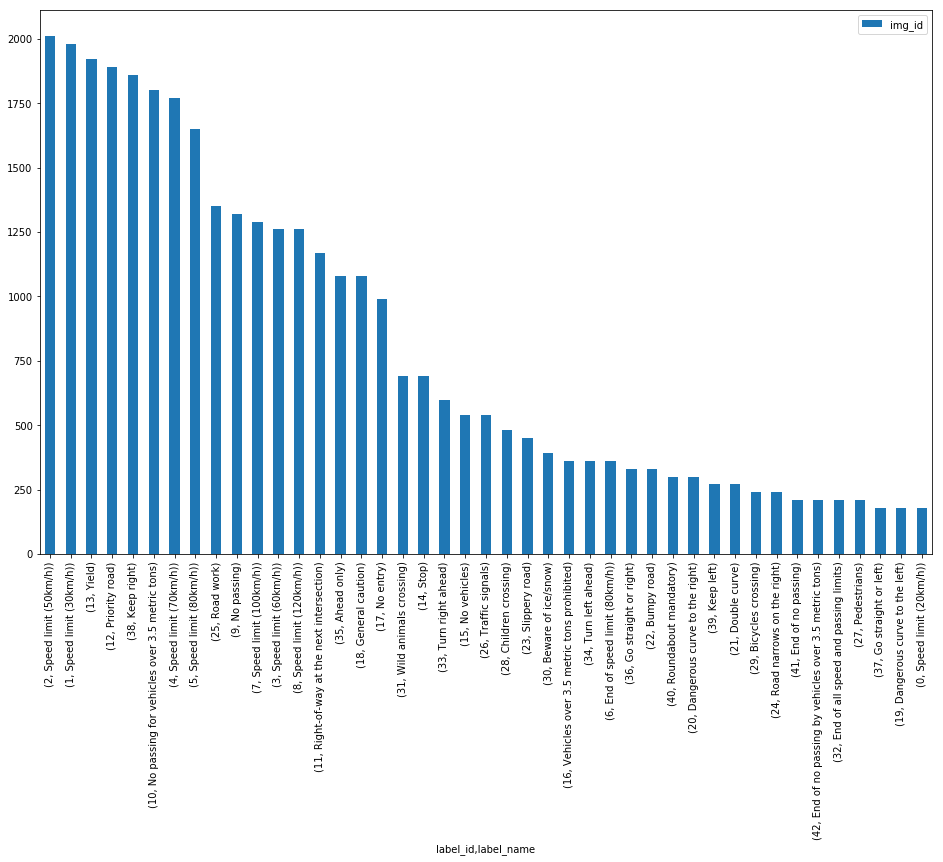

In [39]:
# Plot the chart
X_train_labels_count.sort_values("img_id", ascending=False).plot(kind='bar', figsize=(16, 10))


Finally let's visualize some of the images


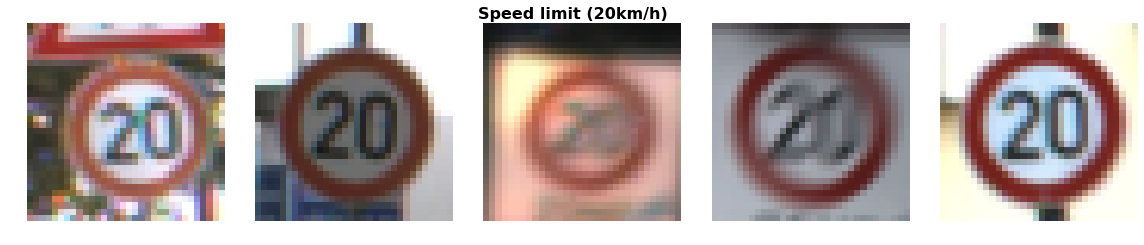

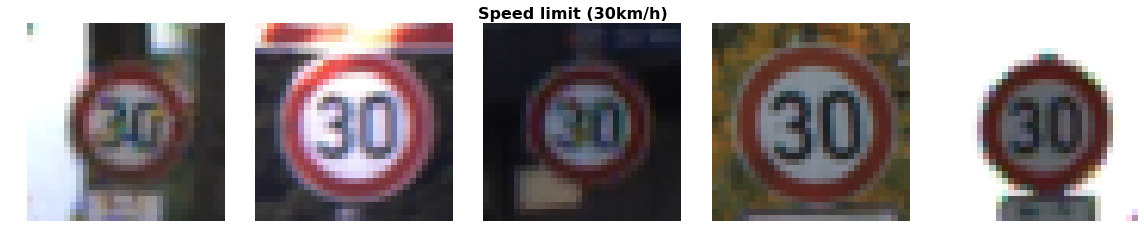

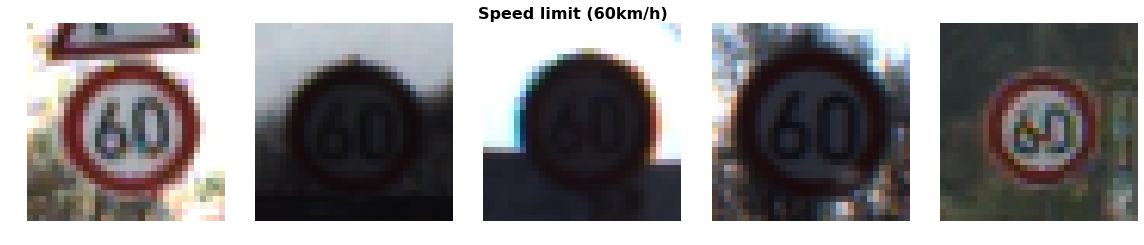

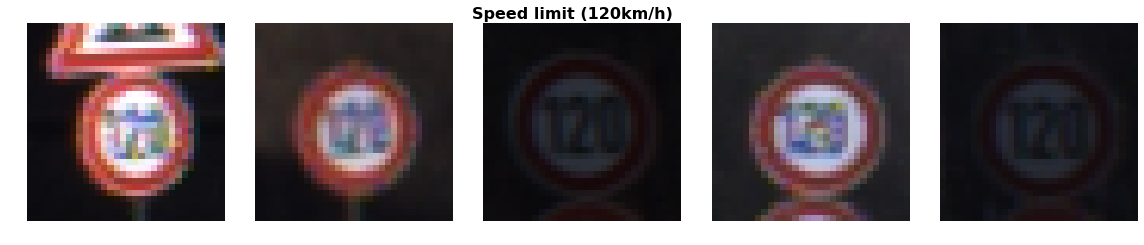

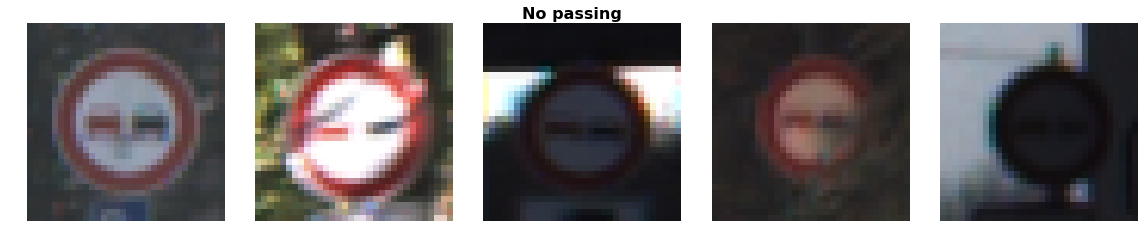

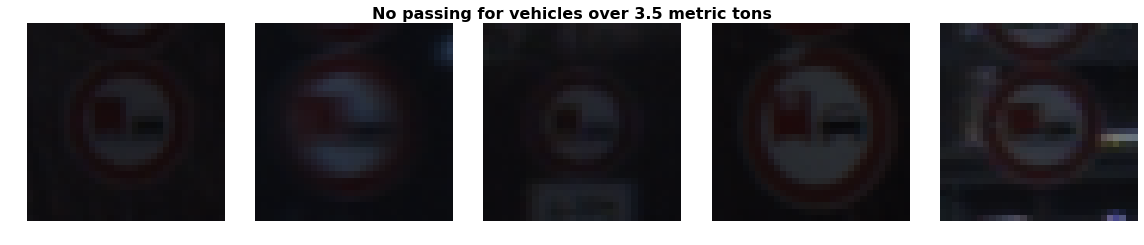

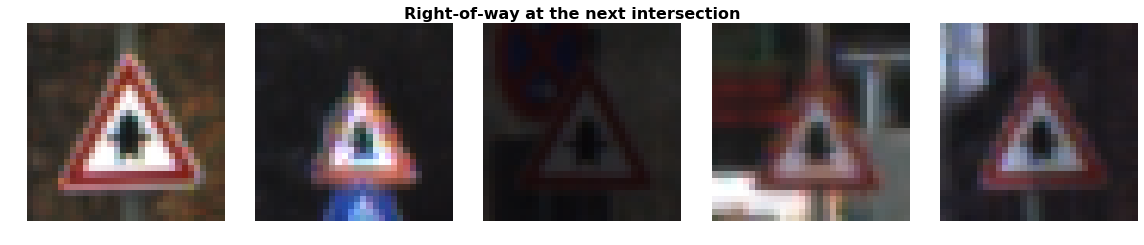

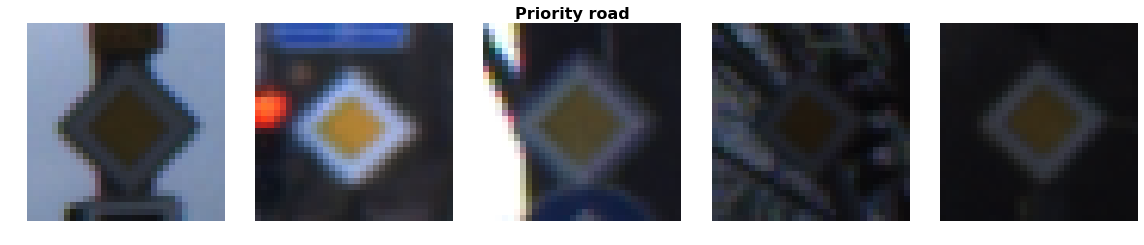

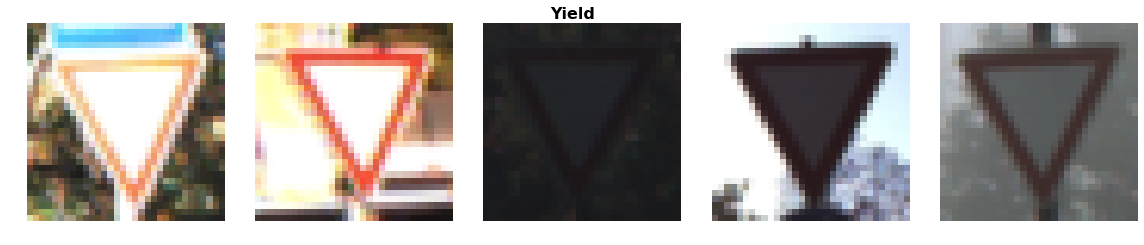

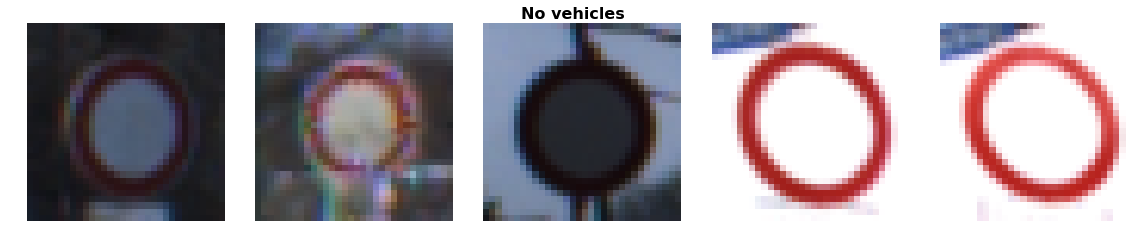

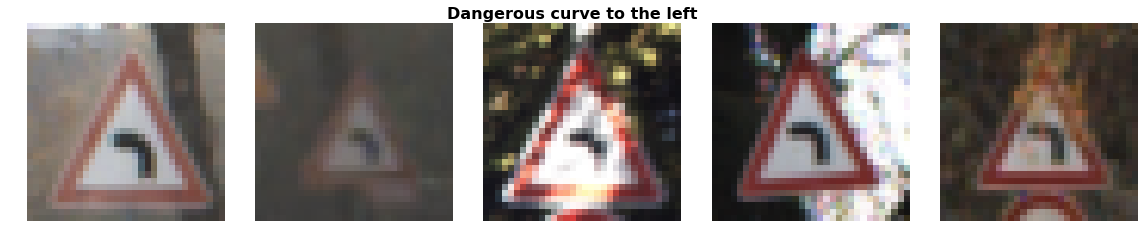

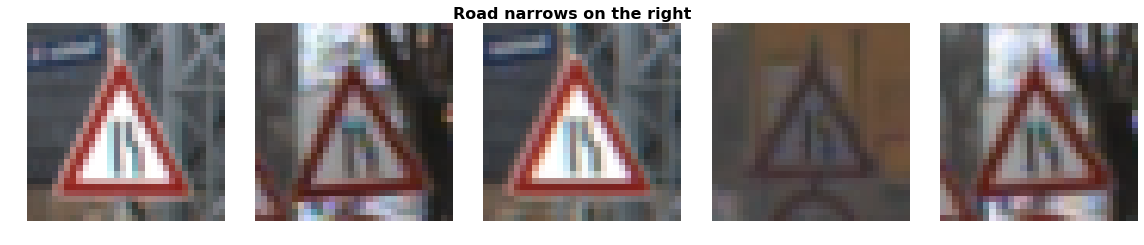

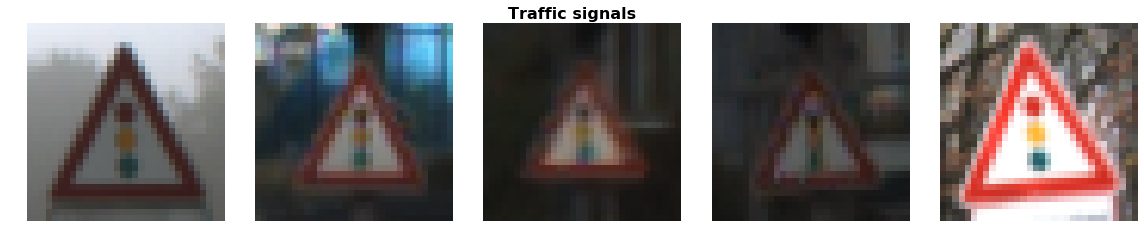

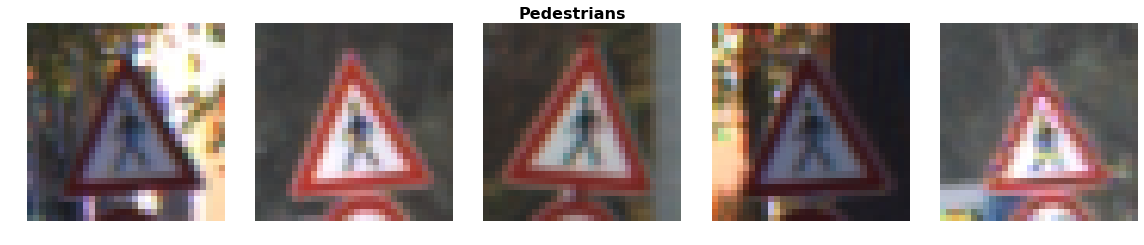

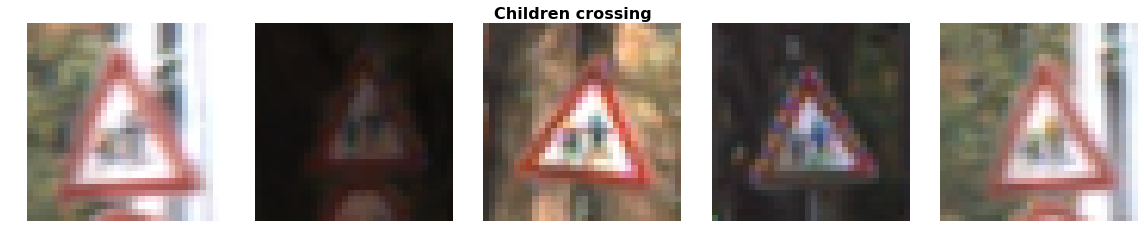

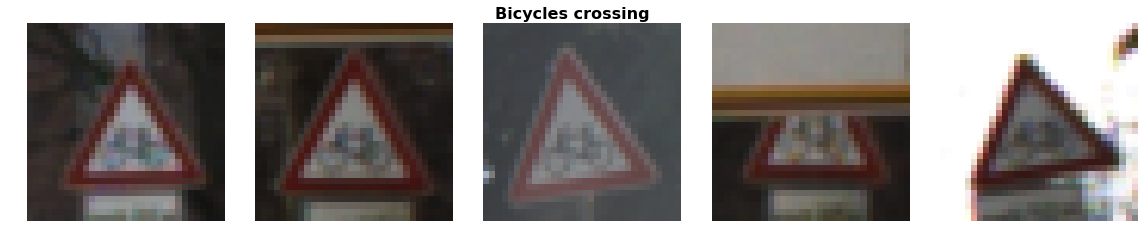

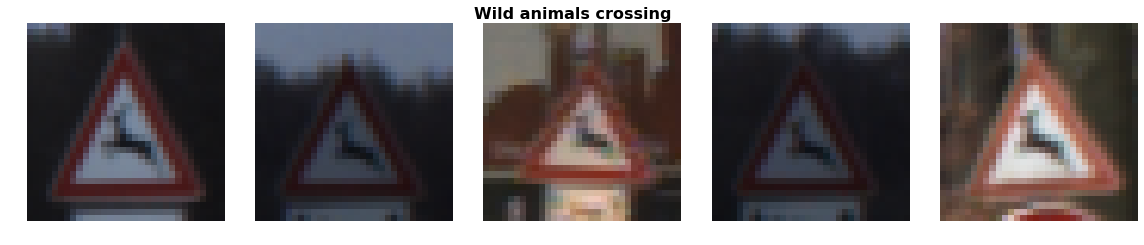

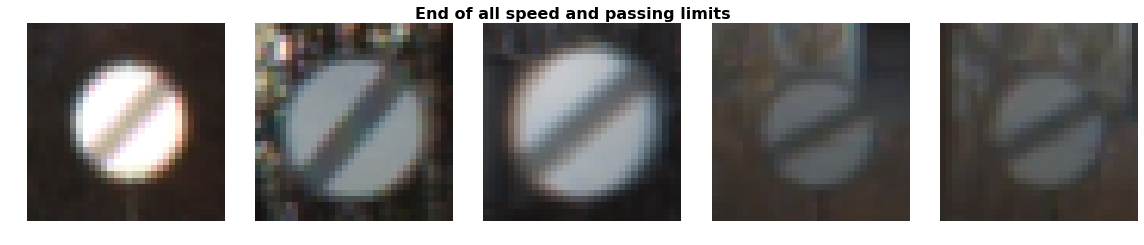

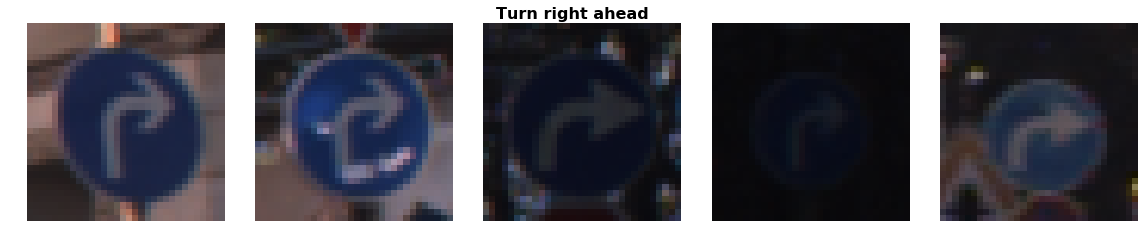

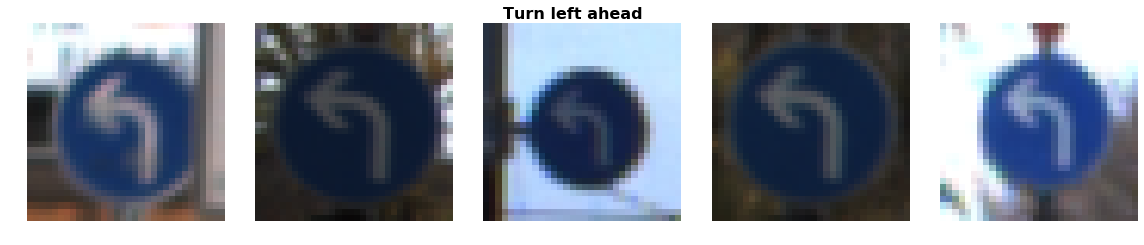

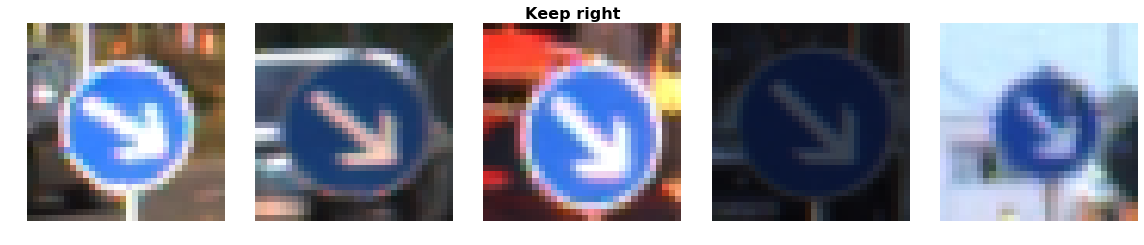

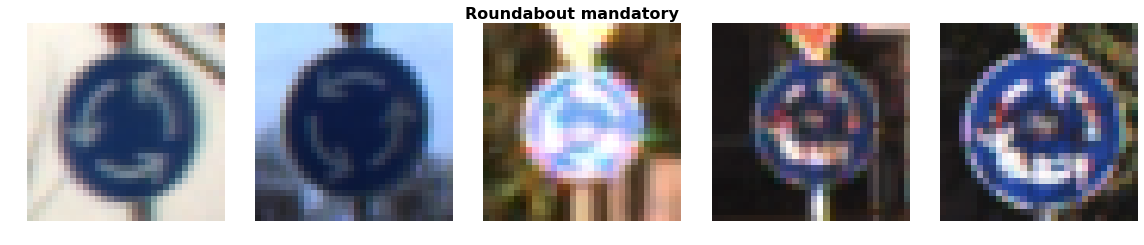

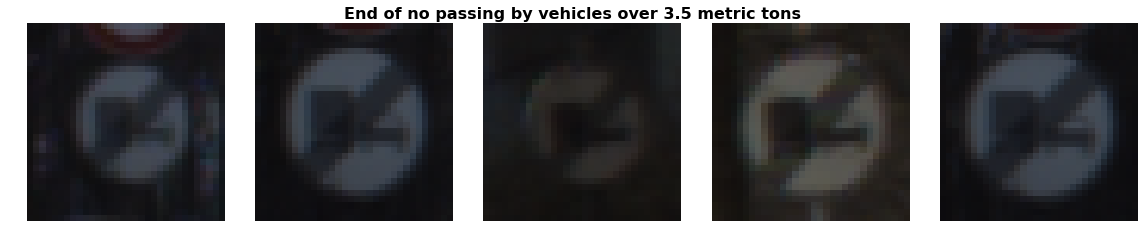

In [44]:
def random_image_plot(labels, imgs, prob_be_shown = 0.5, cols = 5):
    for (label_id, label_name), group in labels:
        if random.random() < prob_be_shown:
            continue
        rand_idx = np.random.randint(0, high=group['img_id'].size, size=cols, dtype='int')
        selected_rows = group.iloc[rand_idx]

        selected_imgs = list(map(lambda img_id: imgs[img_id], selected_rows['img_id']))
        
        rows = len(selected_imgs) // cols
        fig, axes = plt.subplots(rows, cols, figsize=(16, 16))
        for i, img in enumerate(selected_imgs):
            axes[i].axis("off")
            
            axes[i].imshow(img)
            
        fig.suptitle(label_name, fontsize=16, fontweight='bold', y = 0.6)
        fig.tight_layout()
        plt.show()
        

X_train_labels_group = X_train_labels.groupby(["label_id", "label_name"])
random_image_plot(X_train_labels_group, X_train)



----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.


### Model Architecture


In [1]:
### Define a class to handle image manipulations
class ImagesManipulation:
    @staticmethod
    def prepare_batch(features, labels):
        """
        Prepares the data to be processed in a batch, it augements the features and normalizes the images
        :param features: 
        :param labels: 
        :return: 
        """
        features, labels = ImagesManipulation.augment(features, labels)
        features = ImagesManipulation.normalize_imgs(features)
        
        return features, labels
    
    @staticmethod
    def normalize_imgs(imgs):
        """
        Image array normalization
         
        :param imgs: 
        :return: 
        """
        std = np.std(imgs)
        mean = np.mean(imgs)
        return (imgs - mean) / std
    
    @staticmethod
    def augment(features, labels):
        """
        Augment images using flips, rotations and translations
        
        :param features: 
        :param labels: 
        :return: 
        """
        orig_len = len(features)
        
        new_features = features.tolist()
        new_labels = labels.tolist()
        
        tmp_features = [np.fliplr(img) for img in features]
        tmp_labels = [label for label in labels]
        new_features.extend(tmp_features)
        new_labels.extend(tmp_labels)

        for angle in range(-45, 45, 10):
            tmp_features = [ndimage.rotate(img, angle, reshape=False) for img in features]
            tmp_labels = [label for label in labels]
            new_features.extend(tmp_features)
            new_labels.extend(tmp_labels)
                
        t_delta = 5
        tmp_features = [None]*orig_len*4
        tmp_labels = [None]*orig_len*4
        
        for feature_index in range(orig_len):
            img = features[feature_index]
            # Shifting Left
            for i in range(32, 1, -1):
              for j in range(32):
                 if i < 32-t_delta:
                   img[j][i] = img[j][i-t_delta]
                 elif i < 32-1:
                   img[j][i] = 0
            tmp_features[feature_index*4] = img
            tmp_labels[feature_index*4] = labels[feature_index]
            
            # Shifting Right
            img = features[feature_index]
            for j in range(32):
              for i in range(32):
                if i < 32 - t_delta:
                  img[j][i] = img[j][i+t_delta]
                        
            tmp_features[feature_index*4+1] = img
            tmp_labels[feature_index*4+1] = labels[feature_index]
            
            # Shifting Up
            img = features[feature_index]
            for j in range(32):
              for i in range(32):
                if 32 - t_delta > j > t_delta:
                  img[j][i] = img[j+t_delta][i]
                else:
                  img[j][i] = 0
            tmp_features[feature_index*4+2] = img
            tmp_labels[feature_index*4+2] = labels[feature_index]
            
            # Shifting Down
            img = features[feature_index]
            for j in range(32):
              for i in range(32):
                if 16 > j > t_delta:
                  img[j][i] = img[j-t_delta][i]
            tmp_features[feature_index*4+3] = img
            tmp_labels[feature_index*4+3] = labels[feature_index]
            
        new_features.extend(tmp_features)
        new_labels.extend(tmp_labels)
            
        return np.array(new_features), np.array(new_labels)


In [24]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
from tensorflow.contrib.layers import flatten

class TrafficSignNet:
    def __init__(self, learning_rate = 0.001, conv_keep_prob = 0.9, dense_keep_prob=0.75, n_classes = 10):
        """
        Traffic Signs Recognition
        
        :param learning_rate: 
        :param keep_prob: 
        :param n_classes: 
        """
        self.learning_rate = learning_rate
        self.n_classes = n_classes
        self.conv_keep_prob = conv_keep_prob
        self.dense_keep_prob = dense_keep_prob
        self.layer_count = 0
        self.model_stack = []
        # set hyper parameters
        self.mu = 0
        self.sigma = 0.1
        
        self.graph = tf.Graph()
        with self.graph.as_default() as g:
            with g.name_scope("TrafficSignNet") as scope:
                self.build_model()
                self.saver = tf.train.Saver()
                
    def summary(self):
        """
        Prints the model summary
        
        :return: 
        """
        def col(text):
            return str(text) + (" " * (10-len(str(text))))
        
        print("TrafficSignNet Model Summary")
        print("-------------------------------------------------------------")
        
        print(col("Layer"), col("type"), col("in_depth"), col("out_depth"), col("filter_size"))
        for layer in self.model_stack:
            print(
                col(layer['layer']), 
                col(layer['type']), 
                col(layer['in_depth']), 
                col(layer['out_depth']), 
                col(layer['filter_size']))
        print("-------------------------------------------------------------")
                
    def _conv(self, x, in_depth, out_depth, filter_size=5):
        """
        Creates a convolution layer
        
        :param x: 
        :param in_depth: 
        :param out_depth: 
        :param filter_size: 
        :return: convolution layer
        """
        self.layer_count += 1
        self.model_stack.append({
            'layer': self.layer_count,
            'type': 'conv',
            'in_depth': in_depth,
            'out_depth': out_depth,
            'filter_size': 5
        })
        
        conv_w = tf.Variable(tf.truncated_normal(shape=(filter_size, filter_size, in_depth, out_depth), mean=self.mu, stddev=self.sigma))
        conv_b = tf.Variable(tf.zeros(out_depth))
        conv = tf.nn.conv2d(x, conv_w, strides=[1, 1, 1, 1], padding='VALID') + conv_b
        conv = tf.nn.relu(conv, name="layer_{0}".format(self.layer_count))
        
        # Max pooling 
        conv = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
        
        # Dropout
        conv = tf.nn.dropout(conv, self.conv_keep_prob) 
        
        return conv
    
    def _dense(self, x, units, last=False):
        """
        Creates a dense layer
        
        :param x: 
        :param units: 
        :return: dense layer
        """
        self.layer_count += 1
        self.model_stack.append({
            'layer': self.layer_count,
            'type': 'dense',
            'in_depth': x.get_shape().as_list()[-1],
            'out_depth': units,
            'filter_size': None
        })
        
        dense_w = tf.Variable(tf.truncated_normal(shape=(x.get_shape().as_list()[-1], units), mean=self.mu, stddev=self.sigma)) 
        dense_b = tf.Variable(tf.zeros(units))
        dense = tf.matmul(x, dense_w) + dense_b
        if last:
            return dense
        
        dense = tf.nn.relu(dense, name="layer_{0}".format(self.layer_count))
        
        return tf.nn.dropout(dense, self.dense_keep_prob)
        
            
    def build_model(self):
        """
        Builds an LeNet model 
         
        :return: model 
        """
        self.x = tf.placeholder(tf.float32, (None, 32, 32, 3))
        self.y = tf.placeholder(tf.int32, (None))
        self.one_hot_y = tf.one_hot(self.y, self.n_classes)        
        
        layer_1 = self._conv(self.x, in_depth=3, out_depth=32, filter_size=5)
        layer_2 = self._conv(layer_1, in_depth=32, out_depth=64, filter_size=5)
        
        layer_3 = flatten(layer_2)
        layer_4 = self._dense(layer_3, units=120)
        layer_5 = self._dense(layer_4, units=84)
        self.logits = self._dense(layer_5, units=self.n_classes, last=True)
        
        
        self.cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=self.one_hot_y, logits=self.logits)
        self.loss_operation = tf.reduce_mean(self.cross_entropy)
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        self.training_operation = self.optimizer.minimize(self.loss_operation)
        
        self.correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.one_hot_y, 1))
        self.accuracy_operation = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))
        
        self.prediction = tf.argmax(input=self.logits, axis=1)
        self.prediction_top5 = tf.nn.top_k(tf.nn.softmax(self.logits), 5)
    
    def evaluate(self, X_data, Y_data, batch_size):
        """
        Evaluates the model accuracy and loss
        
        :param X_data: 
        :param Y_data: 
        :param batch_size: 
        :return: accuracy, loss
        """
        num_examples = len(X_data)
        total_loss = 0.0
        total_accuracy = 0.0
        sess = tf.get_default_session()
        
        for offset in range(0, num_examples, batch_size):
            batch_x, batch_y = X_data[offset:offset+batch_size], Y_data[offset:offset+batch_size]
            accuracy = sess.run(self.accuracy_operation, feed_dict={self.x: batch_x, self.y: batch_y})
            loss = sess.run(self.loss_operation, feed_dict={self.x: batch_x, self.y: batch_y})
            
            total_accuracy += (accuracy * len(batch_x))
            total_loss += (loss * len(batch_x))
            
        return total_accuracy / num_examples, total_loss / num_examples
        
    
    def train(self, train_features, train_labels, valid_features, valid_labels, epochs = 10, batch_size = 100):
        """
        Trains the model for the given data
        
        :param X_train: 
        :param Y_train: 
        :param epochs: 
        :param batch_size: 
        :return: None
        """
        with tf.Session(graph=self.graph) as sess:
            sess.run(tf.global_variables_initializer())
            num_examples = len(train_features)
            
            print("Training...")
            print()
            for i in range(epochs):
                start_time = time.time()
                x_train_features, y_train_labels = shuffle(train_features, train_labels)
                
                for offset in range(0, num_examples, batch_size):
                    end = offset + batch_size
                    batch_x, batch_y = x_train_features[offset:end], y_train_labels[offset:end]
                    
                    # Augment and encode the data
                    batch_x, batch_y = ImagesManipulation.prepare_batch(batch_x, batch_y)
                    
                    sess.run(self.training_operation, feed_dict={self.x: batch_x, self.y: batch_y}) 
                    
                train_accuracy, train_loss = self.evaluate(train_features, train_labels, batch_size)
                valid_accuracy, valid_loss = self.evaluate(valid_features, valid_labels, batch_size)
                
                if i == 0 or (i+1) % 10 == 0:
                    print("[{}]\t time={:.3f}s | train: [loss: {:.4f} acc={:.4f}] | valid: [loss: {:.4f} acc={:.4f}]".format(
                        i+1, 
                        time.time()-start_time, 
                        train_loss, 
                        train_accuracy, 
                        valid_loss, 
                        valid_accuracy))
                
            self.saver.save(sess, './model/TrafficSignNet')
            print("Model saved!")
        
    def test(self, test_features, test_labels, batch_size = 100):
        """
        Evaluates the model with the given test data
        
        :param test_features: 
        :param test_labels: 
        :param batch_size: 
        :return: accuracy, loss
        """
        with tf.Session(graph=self.graph) as sess:
            sess.run(tf.global_variables_initializer())
            
            self.saver.restore(sess, "./model/TrafficSignNet")

            start = time.time()
            test_features = ImagesManipulation.normalize_imgs(test_features)
            test_accuracy, test_loss = self.evaluate(test_features, test_labels, batch_size)
            print("[Test Set]\ttime={:.3f}s, loss={:.4f}, acc={:.4f}".format(time.time() - start, test_loss, test_accuracy))

        
        return test_accuracy, test_loss
    
    def predict(self, img):
        """
        Predict the right class
        
        :param img: 
        :return: classification
        """
        with tf.Session(graph=self.graph) as sess:
            sess.run(tf.global_variables_initializer())
            
            self.saver.restore(sess, "./model/TrafficSignNet")
            img = ImagesManipulation.normalize_imgs([img])[0]
            
            return sess.run((self.prediction, self.prediction_top5), feed_dict={
                    self.x: np.reshape(img, [1, img.shape[0], img.shape[1], img.shape[2]]),
                })
        
    def print_feature_map(self, img, layer_number, activation_min=-1, activation_max=-1):
        """
        Outputs the feature map
        
        :param image_input: 
        :param tf_activation: 
        :param activation_min: 
        :param activation_max:  
        :return: 
        """
        with tf.Session(graph=self.graph) as sess:
            sess.run(tf.global_variables_initializer())
            
            img = ImagesManipulation.normalize_imgs([img])[0]
            
            self.saver.restore(sess, "./model/TrafficSignNet")
            layer_name = "TrafficSignNet/layer_{0}:0".format(layer_number)
            layer = self.graph.get_tensor_by_name(layer_name)
        
            # run a prediction to load all the tensors
            sess.run((self.prediction, self.prediction_top5), feed_dict={
                    self.x: np.reshape(img, [1, img.shape[0], img.shape[1], img.shape[2]]),
                })
            
            # now activate the layer
            activation = sess.run(layer, feed_dict={
                    self.x: np.reshape(img, [1, img.shape[0], img.shape[1], img.shape[2]]),
                })
            feature_maps = activation.shape[-1]
            
        cols = 6
        rows = (feature_maps // cols) + 1
        fig, axes = plt.subplots(rows, cols, figsize=(16, 16))
        axes = axes.flatten()
        
        fig.suptitle("FeatureMap for Layer: {0}".format(layer_number), fontsize=22, fontweight='bold', y=1.05)
        fig.tight_layout()
        
        for feature_map in range(feature_maps):
            axes[feature_map].axis('off')
            
            if activation_min != -1 & activation_max != -1:
                axes[feature_map].imshow(activation[0,:,:, feature_map], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
            elif activation_max != -1:
                axes[feature_map].imshow(activation[0,:,:, feature_map], interpolation="nearest", vmax=activation_max, cmap="gray")
            elif activation_min !=-1:
                axes[feature_map].imshow(activation[0,:,:, feature_map], interpolation="nearest", vmin=activation_min, cmap="gray")
            else:
                axes[feature_map].imshow(activation[0,:,:, feature_map], interpolation="nearest", cmap="gray")
        
    

### Train, Validate and Test the Model

First we are going to display a model summary


In [27]:
model = TrafficSignNet(learning_rate=0.001, conv_keep_prob=0.9, dense_keep_prob=0.75, n_classes=n_classes)
model.summary()


TrafficSignNet Model Summary
-------------------------------------------------------------
Layer      type       in_depth   out_depth  filter_size
1          conv       3          32         5         
2          conv       32         64         5         
3          dense      1600       120        None      
4          dense      120        84         None      
5          dense      84         43         None      
-------------------------------------------------------------


## Now let's train the model, if the model has already been trained you may skipped this section


In [ ]:
model.train(X_train, y_train, X_valid, y_valid, epochs=100, batch_size=512)


Training...



Now let's evaluate the model against our test data to see it's accuracy


In [9]:
test_accuracy, test_loss = model.test(X_test, y_test)


Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./model/TrafficSignNet
[Test Set]	time=8.360s, loss=0.4523, acc=0.9417


---

## Step 3: Test a Model on New Images

Next we are going to load some sample images and see what our predictions are


INFO:tensorflow:Restoring parameters from ./model/TrafficSignNet
INFO:tensorflow:Restoring parameters from ./model/TrafficSignNet
INFO:tensorflow:Restoring parameters from ./model/TrafficSignNet
INFO:tensorflow:Restoring parameters from ./model/TrafficSignNet
INFO:tensorflow:Restoring parameters from ./model/TrafficSignNet


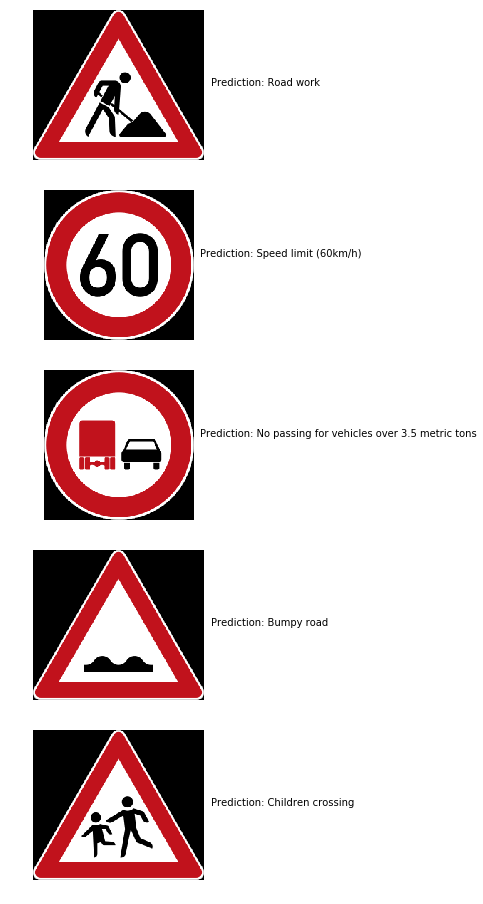

In [26]:
import glob

example_images = []
example_images_label = []
example_images_label_top5 = []
files = glob.glob("examples/*.png")

fig, axes = plt.subplots(len(files), 1, figsize=(16, 16))
for i, img in enumerate(files):
    n = cv2.imread(img)
    n = cv2.cvtColor(n, cv2.COLOR_BGR2RGB)
    example_images.append(n)
    axes[i].imshow(n)
    n = cv2.resize(n, (32, 32))
    
    pred, pred_top5 = model.predict(nn)
    example_images_label.append(sign_names.loc[pred[0]]["SignName"])
    example_images_label_top5.append(pred_top5)
    
    axes[i].axis('off')
    axes[i].annotate("Prediction: " + sign_names.loc[pred[0]]["SignName"],
                     xy=(8,8), xytext=(250,105))
    
plt.show()

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

Let's now take a deeper look into the classification trying to predict the top 5 classes per image



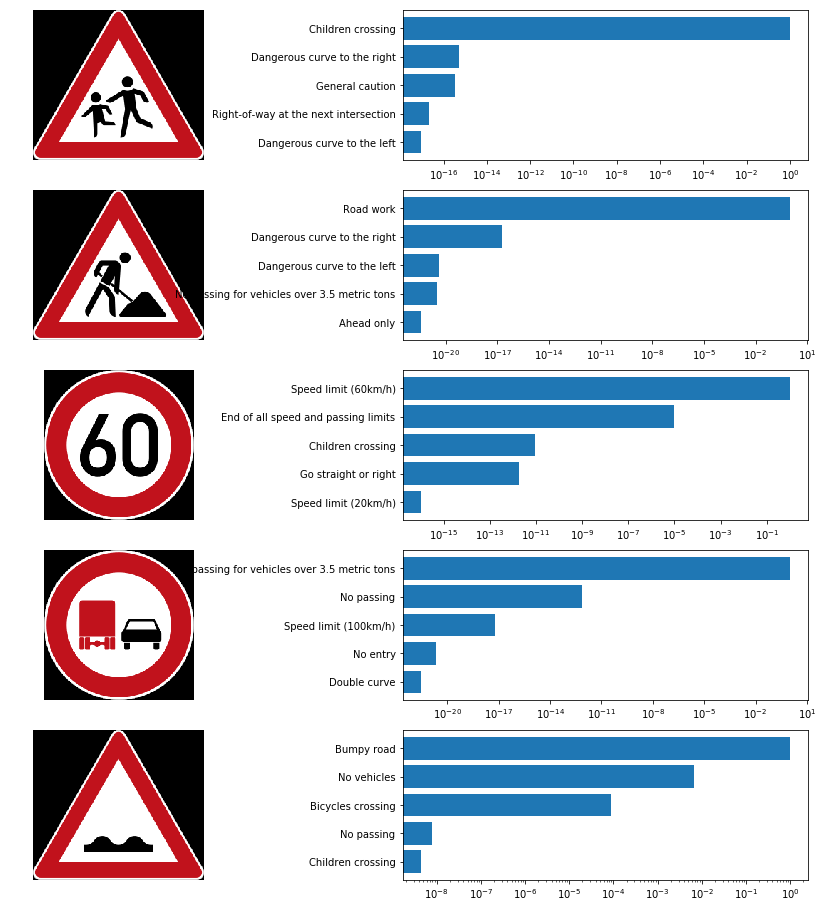

In [11]:
fig, axes = plt.subplots(len(example_images), 2, figsize=(16, 16))
for i, img in enumerate(example_images):
    axes[i][0].imshow(img)
    axes[i][0].axis('off')
    
    labels = [sign_names.loc[s]["SignName"] for s in example_images_label_top5[i].indices[0]]
    
    y_pos = np.arange(5)
    axes[i][1].barh(y_pos, example_images_label_top5[i].values[0])
    axes[i][1].invert_yaxis()
    axes[i][1].set_yticks(y_pos, minor=False)
    axes[i][1].set_yticklabels(labels)
    axes[i][1].set_xscale('log')


---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

Let's examine here what our NN is doing on each layer 


In [60]:

img_file = "./examples/children_crossing.png"
n = cv2.imread(img_file)
n = cv2.cvtColor(n, cv2.COLOR_BGR2RGB)
n = cv2.resize(n, (32, 32))


### Original Image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


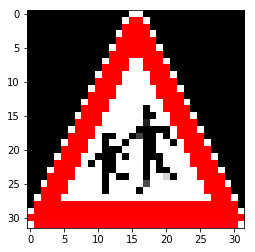

In [63]:
plt.imshow(nn)


### Layer 1


INFO:tensorflow:Restoring parameters from ./model/TrafficSignNet


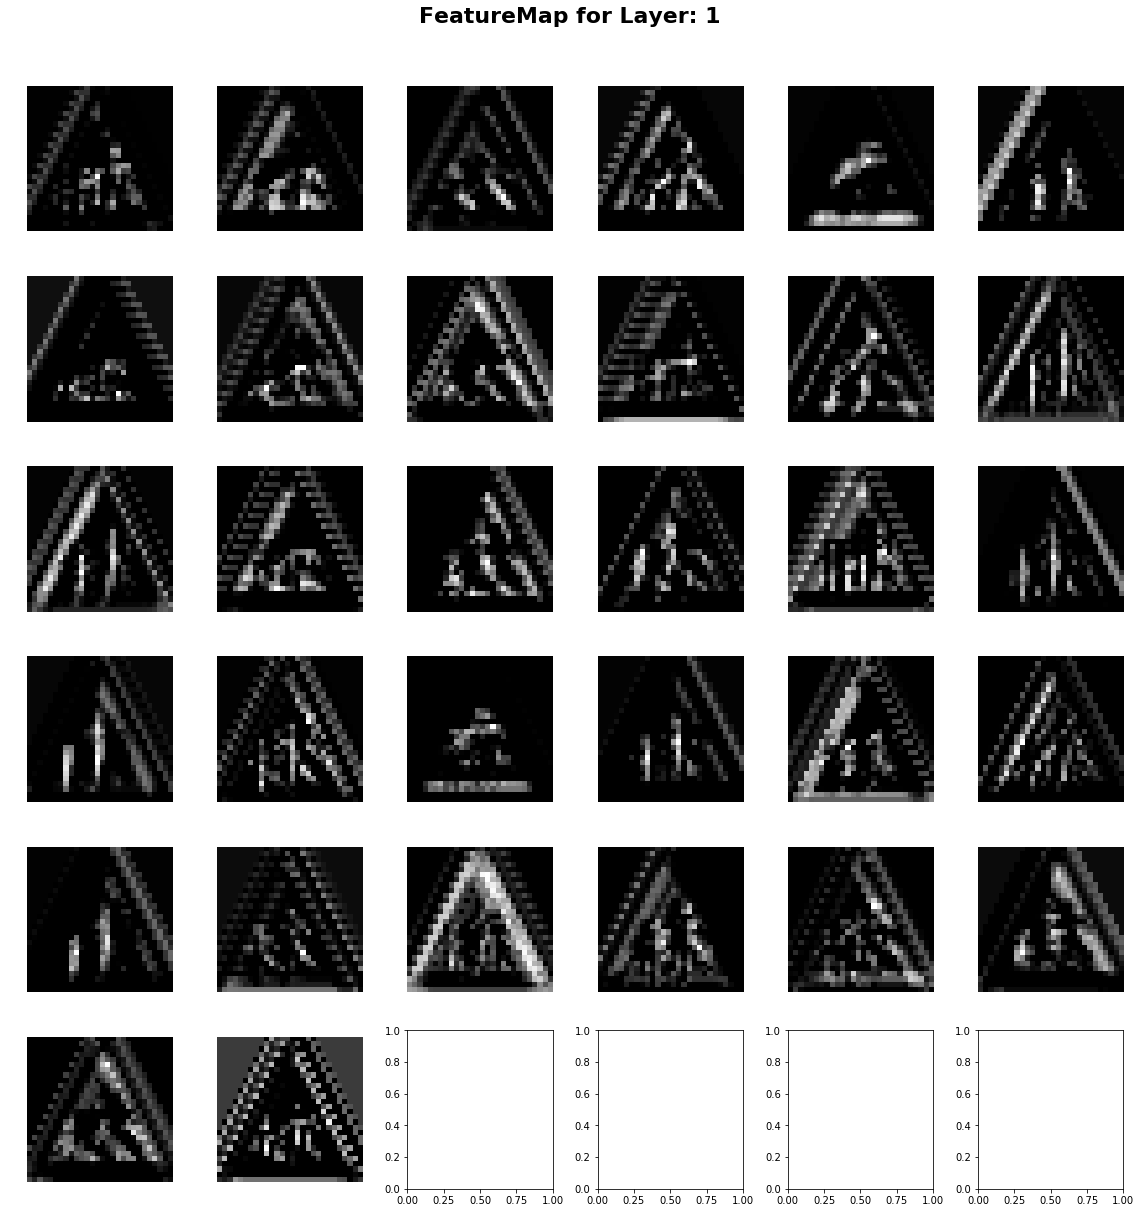

In [64]:
model.print_feature_map(n, layer_number=1)


### Layer 2


INFO:tensorflow:Restoring parameters from ./model/TrafficSignNet


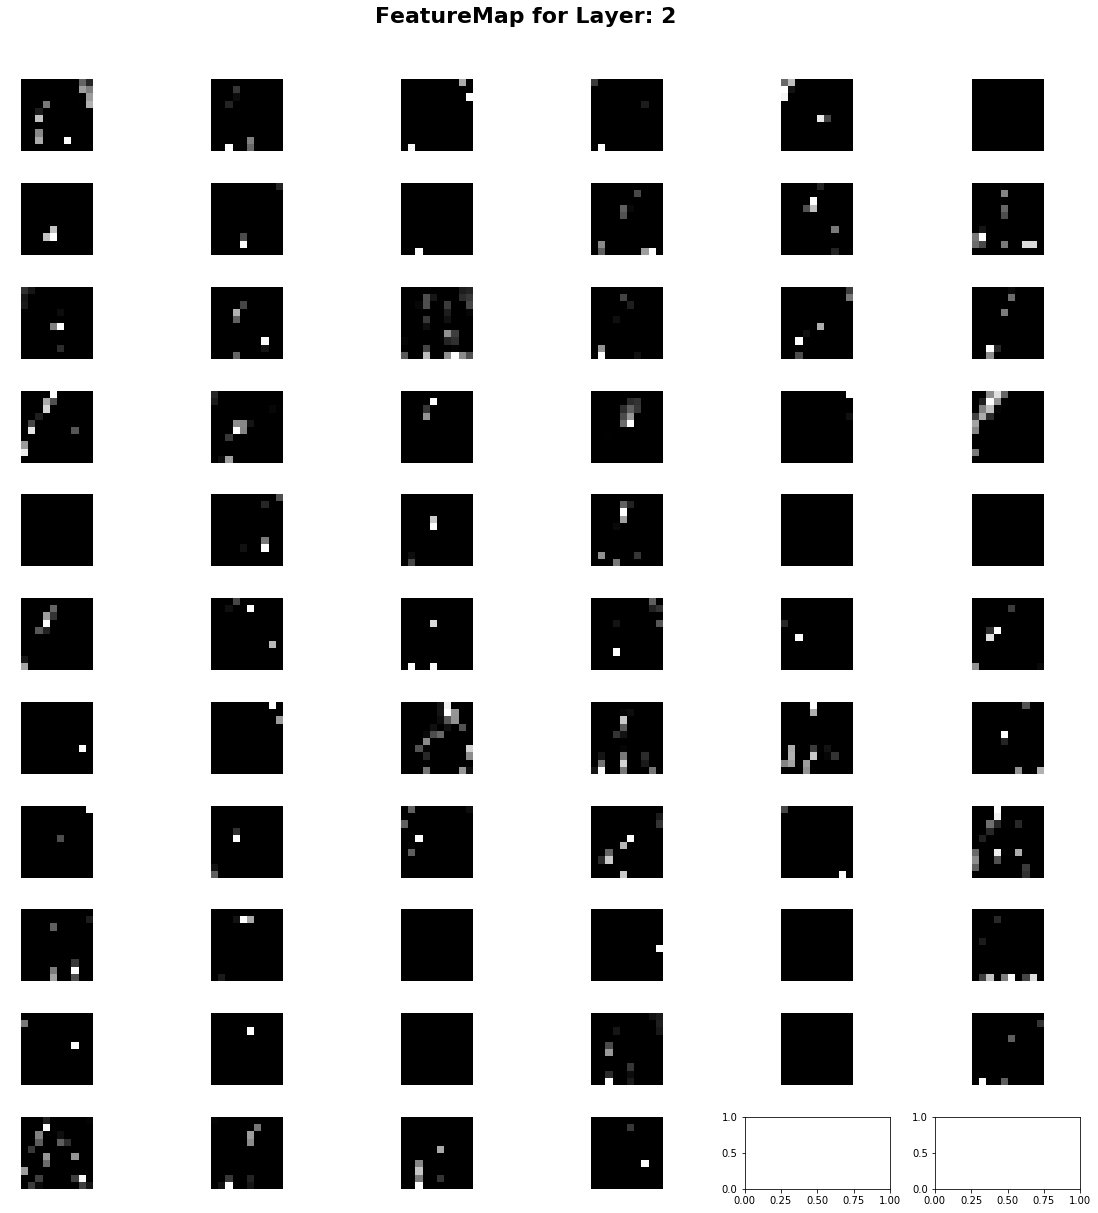

In [62]:
model.print_feature_map(n, layer_number=2)